<a href="https://colab.research.google.com/github/thisisbhupendrasingh/Transformers/blob/main/CiFAR10_Image_Classification_Project_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project completed by me - Bhupendra Pratap Singh
#### Subscribe to my youtube channel: https://www.youtube.com/@dsbybs

# CiFAR10 Image Classification Project using PyTorch
- PyTorch is pre-installed on colab
- It is super popular ML library for training neural networks, especially in deep learning tasks like ours

### Prerequisite
- Enable GPU
- PyTorch is installed

### Step: 1: Import the libraries
Loading the essentials libraries and set seeds for reproducibility

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Set device to GPU if applicable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


### Step 2: Load and Preprocess the Dataset
- we will apply transforms like normalize to mean/std of the dataset and add data augmentation for better training

In [2]:
# Define transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Augmentation: flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Augmentation: random crop
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 stats
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'Training samples: {len(trainset)}, Test samples: {len(testset)}')

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Training samples: 50000, Test samples: 10000


#### Lets see some sample visualization

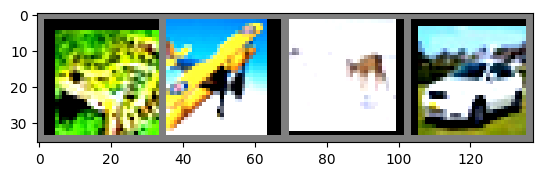

Labels: frog plane deer car


In [3]:
# Visualize a batch
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Denormalize for plotting
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:4]))
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

### Step 3: Define the CNN Model
- Now lets build a simple CNN model with 3 convolutional layer + 1 Max-pooling layer + 2 fully connected layers

In [4]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # In:3x32x32 -> Out:32x32x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Out:64x32x32
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # Out:128x32x32
        self.pool = nn.MaxPool2d(2, 2)  # Halves spatial dims
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # After 3 pools: 128x4x4
        self.fc2 = nn.Linear(512, 10)  # 10 classes
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 64x8x8
        x = self.pool(F.relu(self.conv3(x)))  # 128x4x4
        x = x.view(-1, 128 * 4 * 4)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model
model = CIFAR10CNN().to(device)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Step 4: Training the model
- We will train for 10 epochs and track the accuracy

In [5]:
num_epochs = 10
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 99:  # Print every 100 batches
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}, Loss: {running_loss/100:.3f}')
            running_loss = 0.0

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f'Epoch {epoch+1} - Avg Loss: {epoch_loss:.3f}, Accuracy: {epoch_acc:.2f}%')

print('Training finished!')

Epoch 1/10, Batch 100, Loss: 1.947
Epoch 1/10, Batch 200, Loss: 1.615
Epoch 1/10, Batch 300, Loss: 1.512
Epoch 1 - Avg Loss: 0.334, Accuracy: 39.70%
Epoch 2/10, Batch 100, Loss: 1.354
Epoch 2/10, Batch 200, Loss: 1.309
Epoch 2/10, Batch 300, Loss: 1.218
Epoch 2 - Avg Loss: 0.277, Accuracy: 54.17%
Epoch 3/10, Batch 100, Loss: 1.133
Epoch 3/10, Batch 200, Loss: 1.089
Epoch 3/10, Batch 300, Loss: 1.073
Epoch 3 - Avg Loss: 0.240, Accuracy: 61.56%
Epoch 4/10, Batch 100, Loss: 0.998
Epoch 4/10, Batch 200, Loss: 0.970
Epoch 4/10, Batch 300, Loss: 0.954
Epoch 4 - Avg Loss: 0.217, Accuracy: 66.20%
Epoch 5/10, Batch 100, Loss: 0.926
Epoch 5/10, Batch 200, Loss: 0.900
Epoch 5/10, Batch 300, Loss: 0.885
Epoch 5 - Avg Loss: 0.202, Accuracy: 68.64%
Epoch 6/10, Batch 100, Loss: 0.842
Epoch 6/10, Batch 200, Loss: 0.843
Epoch 6/10, Batch 300, Loss: 0.831
Epoch 6 - Avg Loss: 0.194, Accuracy: 70.66%
Epoch 7/10, Batch 100, Loss: 0.809
Epoch 7/10, Batch 200, Loss: 0.803
Epoch 7/10, Batch 300, Loss: 0.759
E

### Step 5: Model Evaluation
- We will the test the performance of the model on the testing data

In [6]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_acc = 100. * correct / total
print(f'Test Loss: {test_loss/len(testloader):.3f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.629, Test Accuracy: 78.08%


### Step 6: Visualization of Results
- We will plot training curves along with the confusion matrix to visualize the performance of the model on each label

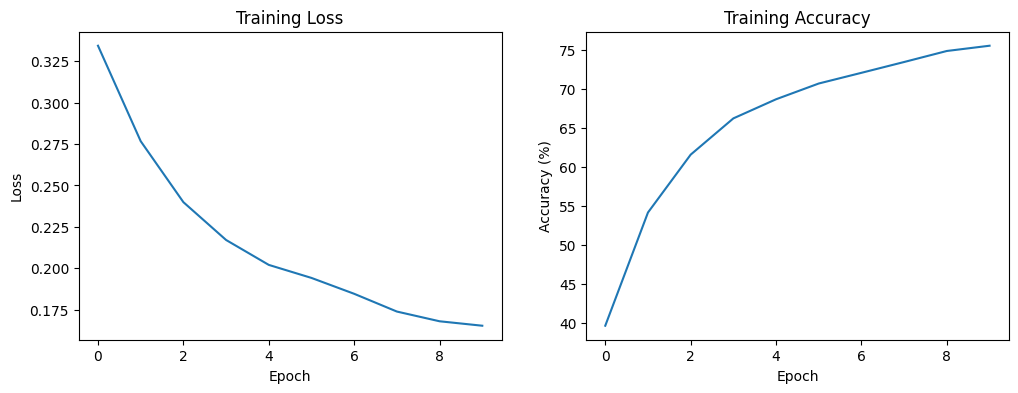

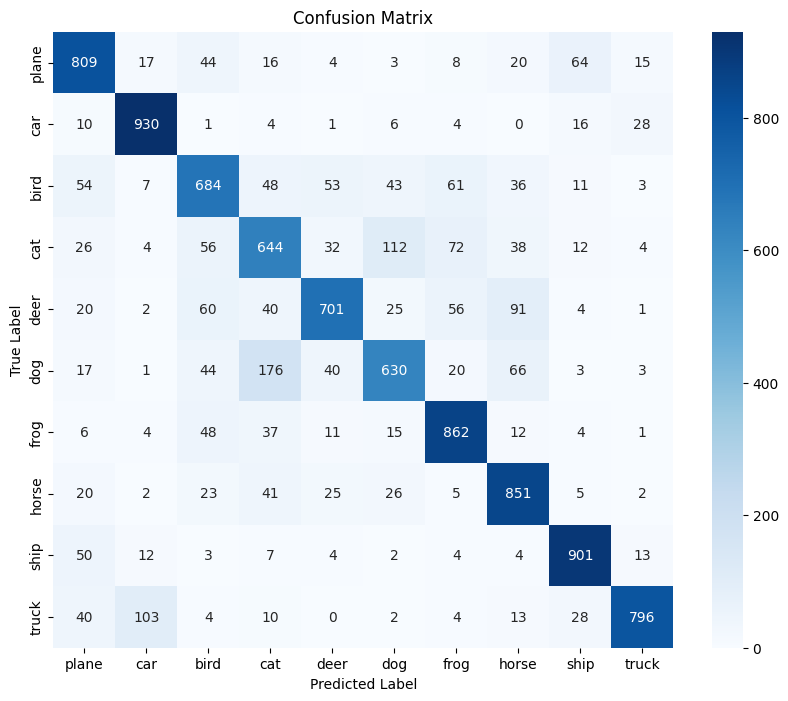

In [7]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# We will draw Confusion Matrix which will require seaborn library import
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()